In [3]:
import importlib
import my_functions

# Reload the module to reflect changes
importlib.reload(my_functions)

# Re-import the functions to update them
from my_functions import *

In [ ]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=3000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi, dr_threshold=0.4)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]

100%|██████████| 3000/3000 [00:03<00:00, 921.03it/s]


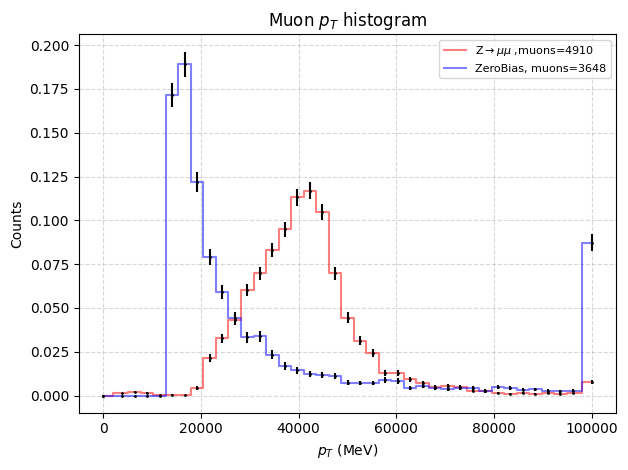

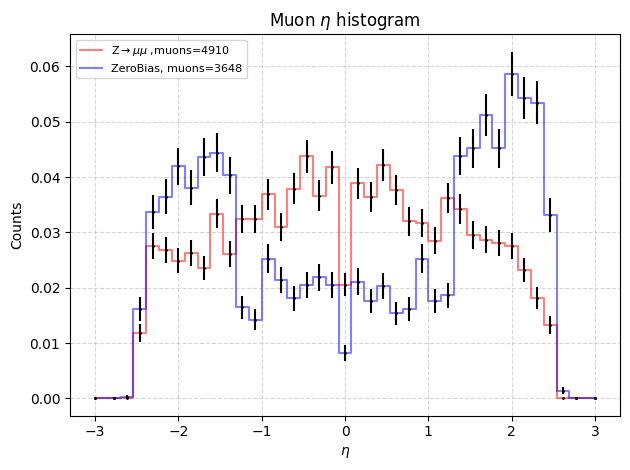

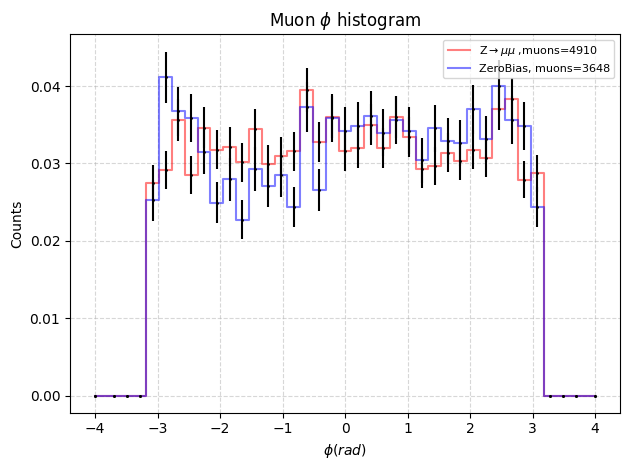

In [ ]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))

coolplot([Zmumu_pt, ZeroBias_pt], np.linspace(0,10*10**4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title="Muon $p_T$ histogram", x_label=r"$p_T$ (MeV)", y_label="Counts", plot_show=False)
plt.savefig('pt_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 40),
         labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts", plot_show=False)
plt.savefig('eta_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 40),
          labels=[rf"Z$\to \mu\mu$ ,muons={l1}", f"ZeroBias, muons={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi (rad)$", y_label="Counts", plot_show=False)
plt.savefig('phi_hist.pdf', format='pdf')
plt.show()

In [ ]:
dr_min=0.1
dr_max=0.3
scaling=1.0

res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                event_range=[nmin1, nmax1], scaling=scaling)
res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                            event_range=[0, len(ZeroBias_eta)], scaling=scaling)

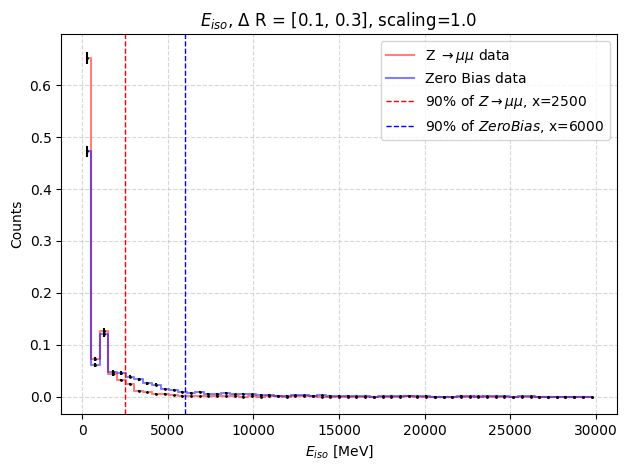

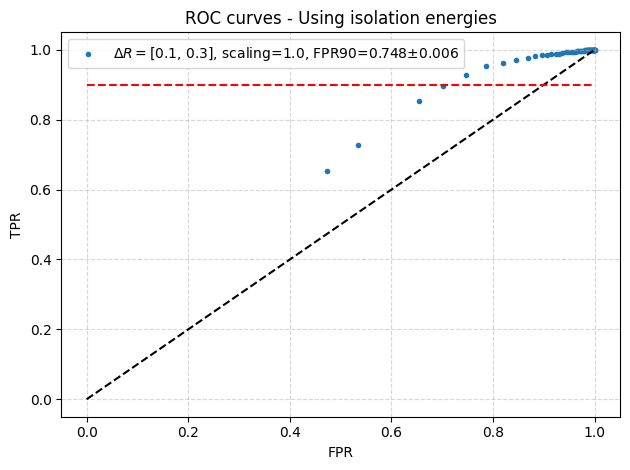

In [ ]:
l3=len(ak.flatten(res1))
l4=len(ak.flatten(res2))
bins=np.linspace(0.00,10000,60)
data1=ak.flatten(res1)
data2=ak.flatten(res2)
Zmumu_counts, _ = np.histogram(data1, bins)
ZeroBias_counts, _ = np.histogram(data2, bins)
#Compute the cumulative sum of the counts (like integrating the histogram to the left)
Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
# Normalize to total events
TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

TPR_90=min(ak.where(TPR >= 0.9)[0])
TPR_90=(TPR_90+1)*((max(bins)-min(bins))/len(bins))

FPR_90=min(ak.where(FPR >= 0.9)[0])
FPR_90=(FPR_90+1)*((max(bins)-min(bins))/len(bins))

coolplot([res1, res2],bins, plot_show=False, collect_overflow=False, x_label=r"$E_{iso}$ [MeV]",
    y_label="Counts", title=fr"$E_{{iso}}$, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scaling}",
    labels=[rf"$Z\to\mu\mu$, muons={l3}", rf"Zero Bias, muons={l4}"])
plt.axvline(x=TPR_90, color='r', linestyle='--', linewidth=1, label=rf"90% of $Z\to\mu\mu$, x={int(TPR_90)}")
plt.axvline(x=FPR_90, color='b', linestyle='--', linewidth=1, label=rf"90% of $ZeroBias$, x={int(FPR_90)}")
plt.legend()
plt.show()

#Plot ROC
FPR90=min(FPR[TPR >= 0.9])
err=FPR_uncertainty(FPR90, len(data1))
plt.scatter(FPR, TPR, marker='.', 
            label=fr'$\Delta R=$[{dr_min}, {dr_max}], scaling={scaling}, FPR90={np.round(FPR90,3)}$\pm${np.round(err,3)}')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title(rf"ROC curves - Using isolation energies")
plt.tight_layout()

In [ ]:
points=4
iterations=1
next_dr_mins=np.linspace(0,0.15,points)
next_dr_maxs=np.linspace(0.10,0.40,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [0, len(ZeroBias_pt)],
                   min_range, max_range, points, bins=bins, scaling=scaling, use_ratio=False)

FPR_effs_not_none=FPR_effs[FPR_effs != None]

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs_not_none, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])

Step 1 out of 16


Step 2 out of 16


Step 3 out of 16


Step 4 out of 16


KeyboardInterrupt: 